In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
try:
    import neurolib
except ImportError:
    import sys
    !{sys.executable} -m pip install neurolib
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

# Exploring models

Bifurcation diagrams can give us an overview of how different parameters of the model affect its dynamics. The simplest method for drawing a bifurcation diagram is to simply change relevant parameters step by step and record the model's behavior in response to these changes. In this example, we want to see how the model's dynamics changes with respect to the **external input currents** to the excitatory population. These input currents could be due to couplings with other nodes in a brain network or we could model other factors like external electrical stimulation. 

Below, you can see a schematic of the `aln` model. As you can see, a single node consists of one excitatory (red) and one inhibitory population (blue). The parameter that controls the mean input to the excitatory population is $\mu_{E}$ or `model.params["mue_ext_mean"]`.

<p align="center">
  <img src="../resources/aln.png" width="400">
</p>

Let's first decrease the duration of a single run so we can scan the parameter space a bit faster and let's also disable the noisy input.

In [6]:
# Create the model
model = ALNModel()
model.params['duration'] = 1.0 * 1000  
model.params['sigma_ou'] = 0.0

Let's fix the input to the inhibitory population:

In [7]:
model.params['mui_ext_mean'] = 0.5

We draw a one-dimensional bifurcation diagram, so it is enough to loop through different values of `mue_ext_mean` and record the minimum and maximum of the rate for each parameter.

## Parameter exploration - by hand

This simple code block shows the basic idea of how a parameter exploration works: We define a range of parameters (`mue_inputs = np.linspace(0, 2, 50)`) and run the model for each combination. In this example, we only have one parameter that we change (`mue_ext_mean`). However, we could do the same thing for two or more parameters which would result in 2D or higher-dimensional results.

After running each parameter combination, we compute the desired result for each run. In this case, we want to know the maximum and the minium firing rate of a single run in order to determine an oscillation amplitude if oscillations are present. 

We only use the last 500 ms of each run (given by `-int(500/model.params['dt']):`) so we safely ignore transitory effects at the start of each simulation. We add these results to a list and store them for plotting.

In [8]:
max_rate_e = []
min_rate_e = []
# these are the different input values that we want to scan
mue_inputs = np.linspace(0, 2, 50)
for mue in mue_inputs:
    model.params['mue_ext_mean'] = mue
    model.run()
    # we add the maximum and the minimum of the last 500 ms of the 
    # simulation to a list
    max_rate_e.append(np.max(model.output[0, -int(500/model.params['dt']):]))
    min_rate_e.append(np.min(model.output[0, -int(500/model.params['dt']):]))

Let's plot the results!

Text(0, 0.5, 'Min / max firing rate')

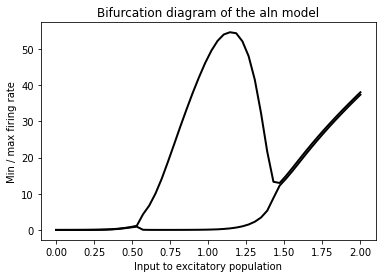

In [9]:
plt.plot(mue_inputs, max_rate_e, c='k', lw = 2)
plt.plot(mue_inputs, min_rate_e, c='k', lw = 2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate")

# Parameter expliraiton using the `BoxSearch` class

The `BoxSearch` class is the main vehicle using which we will run parameter explirations in `neurolib`. It manages the parameter space and the results and saves them on the disk for further analysis. This module heavily relies on `pypet` ([GitHub](https://github.com/SmokinCaterpillar/pypet)) which is a parameter exploration toolkit, and will soon also support `mopet` ([GitHub](https://github.com/caglorithm/mopet))- a light-weight alternative to `pypet`. 

## 1D bifurcation diagram

In this first example, we will demonstrate how we can use the `BoxSearch` class to reproduce the manual exploration above.

In [10]:
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch

# Create the model
model = ALNModel()
model.params['duration'] = 1 * 1000
model.params['mui_ext_mean'] = 0.5

We set the same parameter range as in the previous example.

In [11]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 2, 25)})
search = BoxSearch(model, parameters)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 25
MainProcess root INFO     BoxSearch: Environment initialized.


In [12]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-27-13H-28M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-27-13H-28M-45S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-06-27-13H-28M-45S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-27-13H-28M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [13]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/exploration.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-27-13H-28M-45S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-27-13H-28M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 25/25 [00:00<00:00, 354.53it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 25/25 [00:00<00:00, 3648.62it/s]
MainProcess root INF

In [14]:
print("Number of results: {}".format(len(search.results)))

Number of results: 25


In [15]:
search.results

{0: {'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03]),
  'rates_exc': array([[7.30570362e+00, 6.55573213e+00, 5.89946165e+00, ...,
          5.80685004e-04, 5.80688696e-04, 5.80692386e-04]])},
 1: {'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03]),
  'rates_exc': array([[7.30570362e+00, 6.55573213e+00, 5.90010372e+00, ...,
          2.51886998e-03, 2.51888710e-03, 2.51890422e-03]])},
 2: {'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03]),
  'rates_exc': array([[7.30570362, 6.55573213, 5.90074579, ..., 0.00973769, 0.00973776,
          0.00973783]])},
 3: {'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03]),
  'rates_exc': array([[7.30570362, 6.55573213, 5.90138786, ..., 0.03527377, 0.03527396,
          0.03527416]])},
 4: {'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03]),
 

In [16]:
search.results[0]

{'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
        1.000e+03]),
 'rates_exc': array([[7.30570362e+00, 6.55573213e+00, 5.89946165e+00, ...,
         5.80685004e-04, 5.80688696e-04, 5.80692386e-04]])}

### Postprocessing - min and max rate

In [17]:
for key, value in search.results.items():
    search.results[key]["max_r"] = np.max(search.results[key]['rates_exc'][0, -int(500/model.params['dt']):])
    search.results[key]["min_r"] = np.min(search.results[key]['rates_exc'][0, -int(500/model.params['dt']):])

In [18]:
search.results[0]

{'t': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
        1.000e+03]),
 'rates_exc': array([[7.30570362e+00, 6.55573213e+00, 5.89946165e+00, ...,
         5.80685004e-04, 5.80688696e-04, 5.80692386e-04]]),
 'max_r': 0.0005806923861852579,
 'min_r': 0.0004982151637033186}

Text(0, 0.5, 'Min / max firing rate')

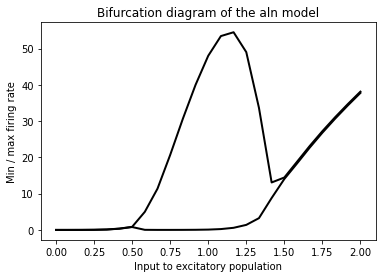

In [19]:
plt.plot(parameters.mue_ext_mean, [value['max_r'] for key, value in search.results.items()], c='k', lw = 2)
plt.plot(parameters.mue_ext_mean, [value['min_r'] for key, value in search.results.items()], c='k', lw = 2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate")

## 2D bifurcation diagram

In [20]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0.1, 3, 10), "mui_ext_mean": np.linspace(0.1, 3, 10)})

search = BoxSearch(model, parameters)

MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Number of processes: 10
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 100
MainProcess root INFO     BoxSearch: Environment initialized.


In [21]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-27-13H-29M-46S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-27-13H-29M-46S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-06-27-13H-29M-46S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-27-13H-29M-46S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

## Loading the exploration results from disk

In [22]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/exploration.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-27-13H-29M-46S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-27-13H-29M-46S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 100/100 [00:00<00:00, 363.06it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 100/100 [00:00<00:00, 4195.69it/s]
MainProcess root

In [23]:
print("Number of results: {}".format(len(search.results)))

Number of results: 100


In [24]:
search.dfResults

,mue_ext_mean,mui_ext_mean,t,rates_exc
0,0.1,0.100000,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002..."
1,0.1,0.422222,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002..."
2,0.1,0.744444,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002..."
3,0.1,1.066667,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002..."
4,0.1,1.388889,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002..."
...,...,...,...,...
95,3.0,1.711111,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225..."
96,3.0,2.033333,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225..."
97,3.0,2.355556,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225..."
98,3.0,2.677778,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225..."


In [28]:
# Example analysis of the results
# The .results attribute is a list and can be indexed by the run 
# number (which is also the index of the pandas dataframe .dfResults).
# Here we compute the maximum firing rate of the node in the last second
# and add the result (a float) to the pandas dataframe.
for i in search.dfResults.index:
    search.dfResults.loc[i, 'max_r'] = np.max(search.results[i]['rates_exc'][:, -int(500/model.params['dt']):])
    search.dfResults.loc[i, 'amp'] = search.dfResults.loc[i, 'max_r'] - np.min(search.results[i]['rates_exc'][:, -int(500/model.params['dt']):])

In [29]:
search.dfResults

,mue_ext_mean,mui_ext_mean,t,rates_exc,max_r,amp
0,0.1,0.100000,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002...",2.135957e-01,5.583848e-02
1,0.1,0.422222,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002...",7.786616e-03,1.029428e-03
2,0.1,0.744444,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002...",8.899758e-05,1.262908e-05
3,0.1,1.066667,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002...",7.989914e-08,1.624939e-08
4,0.1,1.388889,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9002...",3.898084e-10,0.000000e+00
...,...,...,...,...,...,...
95,3.0,1.711111,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225...",6.613773e+01,2.937899e-01
96,3.0,2.033333,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225...",6.526187e+01,2.963181e-01
97,3.0,2.355556,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225...",6.456042e+01,2.982186e-01
98,3.0,2.677778,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[7.3057036154411215, 6.55573212918865, 5.9225...",6.398624e+01,2.996421e-01


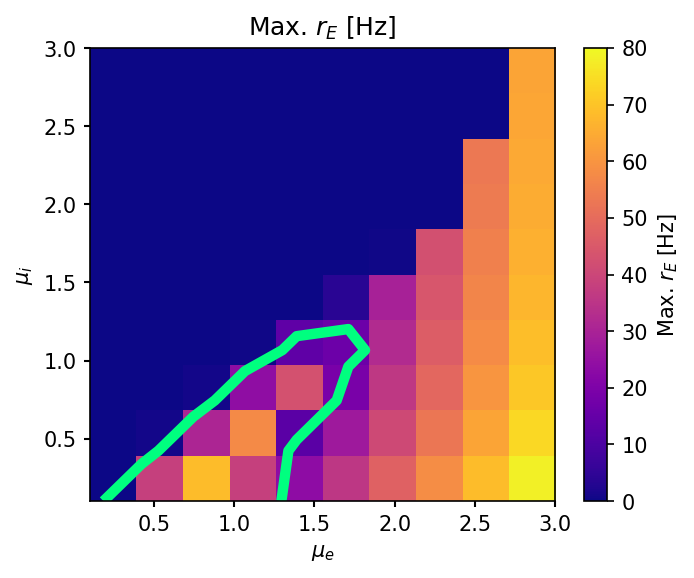

In [30]:
import neurolib.optimize.exploration.explorationUtils as eu

eu.plotExplorationResults(search.dfResults, 
                          par1=['mue_ext_mean', '$\mu_e$'], 
                          par2=['mui_ext_mean', '$\mu_i$'], 
                          plot_key='max_r',
                          plot_clim=[0.0, 80.0],
                          nan_to_zero=False,
                          plot_key_label="Max. $r_E$ [Hz]", 
                          one_figure=False,
                          contour=["amp"],
                          contour_color=[['springgreen']],
                          contour_levels=[[10]],
                          contour_alpha=[1.0],
                          contour_kwargs={0 : {"linewidths" : (5,)}, 1 : {"linestyles" : "--", "linewidths" : (5,)}},
                         )

# 2 - Parameter exploration with custom evaluation function

## Define the evaluation function
Here we define a very simple evaluation function. The function needs to take in `traj` as an argument, which is the pypet trajectory. This is how the function knows what parameters were assigned to it. Using the builtin function `search.getParametersFromTraj(traj)` we can then retrieve the parameters for this run. They are returned as a dictionary and can be accessed in the function. 

In the last step, we use `search.saveToPypet(result_dict, traj)` to save the results to the pypet trajectory and to an HDF. In between, the computational magic happens!

In [32]:
parameters = ParameterSpace({"x": np.linspace(-2, 2, 21), "y": np.linspace(-2, 2, 21)})

MainProcess root INFO     Assuming parameter kind "grid"


In this example, we define a toy example: The evaluation function will simply be the distance of an x and y coordinate to the unit circle. In a real-world experiment, this function would actually run a model and make some measurements on its outputs that should be stored. An example would be to run a model and measure the dominant oscillation frequency and store that value.

In [33]:
def explore_me(traj):
    pars = search.getParametersFromTraj(traj)
    result_dict = {"distance" : abs((pars['x']**2 + pars['y']**2) - 1)}
    search.saveToPypet(result_dict, traj)

MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Number of processes: 10
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 441
MainProcess root INFO     BoxSearch: Environment initialized.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-43M-22S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-23-13H-43M-22S`.
MainProcess pypet.environment.Environment INFO     
**************

## Define the parameter space and exploration

Here we define which space we want to cover. For this, we use the builtin class `ParameterSpace` which provides a very easy interface to the exploration. To initialize the exploration, we simply pass the evaluation function and the parameter space to the `BoxSearch` class.

In [34]:
parameters = ParameterSpace({"x": np.linspace(-2, 2, 40), "y": np.linspace(-2, 2, 40)})
search = BoxSearch(evalFunction = explore_me, parameterSpace = parameters, filename="example-1.1.hdf")

MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Number of processes: 10
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.1.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 1600
MainProcess root INFO     BoxSearch: Environment initialized.


## Run

And off we go!

In [35]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-43M-28S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-23-13H-43M-28S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-06-23-13H-43M-28S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-43M-28S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

## Get results

We can easily obtain the results from pypet. First we call `search.loadResults()` to make sure that the results are loaded from the hdf file to our instance.

In [36]:
search.loadResults()
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from ./data/hdf/example-1.1.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-23-13H-43M-28S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.1.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-23-13H-43M-28S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 1600/1600 [00:02<00:00, 651.09it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 1600/1600 [00:00<00:00, 7955.18it/s]
MainProcess 

Number of results: 1600


The runs are also ordered in a simple pandas dataframe called `search.dfResults`. We cycle through all results by calling `search.results[i]` and loading the desired result (here the distance to the circle) into the dataframe

In [37]:
search.dfResults

,x,y,distance
0,-2.0,-2.000000,7.000000
1,-2.0,-1.897436,6.600263
2,-2.0,-1.794872,6.221565
3,-2.0,-1.692308,5.863905
4,-2.0,-1.589744,5.527285
...,...,...,...
1595,2.0,1.589744,5.527285
1596,2.0,1.692308,5.863905
1597,2.0,1.794872,6.221565
1598,2.0,1.897436,6.600263


And of course a plot can visualize the results very easily.

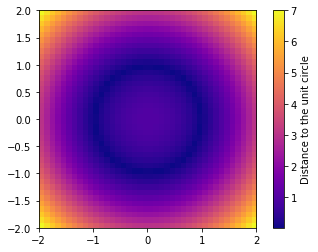

In [38]:
plt.imshow(search.dfResults.pivot_table(values='distance', index = 'x', columns='y'), \
           extent = [min(search.dfResults.x), max(search.dfResults.x),
                     min(search.dfResults.y), max(search.dfResults.y)], origin='lower')
plt.colorbar(label='Distance to the unit circle')

# 3 - Brain network exploration

We now move to a more realistic example. In the next two experiments, we are going to simulate a whole-brain network for one minute per parameter combination. We will then measure the fit of the simulated functional connectivity matrix to the empirical data set. This is a common practice in whole-brain modeling, since we are often interested in finding parameters that reproduce the real data best.

First, we will explore the parameter that controls the strengh of the input to the excitatory populations (in each brain area) called `mue_ext_mean`. This represents a movement on the x-axis of the bifurcation diagram of the model that we have plotted above. 

Next, we will do a similar exploration but this time with the global coupling strengh parameter `Ke_gl`. This parameter controls how strongly the brain areas are connected to each other, influencing the correlation between the different brain areas. 

First, we load an epmirical dataset.

In [39]:
from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

MainProcess root INFO     Loading dataset hcp from /Users/cc/Documents/PhD/projects/neurolib/neurolib/utils/../data/datasets/hcp.
MainProcess root INFO     Dataset hcp loaded.


## Set up model

We set the model parameters to "good" values that we have identified before. 

In [40]:
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
model.params['sigma_ou'] = 0.09
model.params['b'] = 5.0
model.params['dt'] = 0.2
model.params['duration'] = 1.0 * 60 * 1000 #ms

MainProcess root INFO     aln: Model initialized.


## Define evaluation function

Similar to the toy example with the unit circle, we now define an evaluation function, but this time with a more useful objective.

This function will be called for each parameter combination. First, it loads the model (and its parameters). Next, we make sure that each simulation has random initial conditions. 

One useful trick in this function is to do a *stagewise* simulation: We don't want to run the model for the entire length of the simulation without first checking whether it produces any activity after all. For man parameter combinations, the model simply won't output any useful activity at all. This check will save us a lot of computation time as we run many simulations with different parameters throughout the exploration.

If the model seems to produce any activity, we then (in stage 3) run the full simulation and evaluate the model fit.

The model fit is determined by measuring the FC fit (using `func.matrix_correlation`) and the FCD fit (using `func.ts_kolmogorov`). We then store the fits for each run.

In [1]:
def evaluateSimulation(traj):
    # get the model from the trajectory using `search.getModelFromTraj(traj)`
    model = search.getModelFromTraj(traj)
    # initiate the model with random initial contitions
    model.randomICs()
    defaultDuration = model.params['duration']
    invalid_result = {"fc" : np.nan, "fcd" : np.nan}
    
    # -------- STAGEWISE EVALUATION  --------
    stagewise = True
    if stagewise:
        # -------- stage wise simulation --------

        # Stage 1 : simulate for a few seconds to see if there is any activity
        # ---------------------------------------
        model.params['duration'] = 3*1000.
        model.run()

        # check if stage 1 was successful
        amplitude = np.max(model.output[:, model.t > 500]) - np.min(model.output[:, model.t > 500])
        if amplitude < 0.05:
            search.saveToPypet(invalid_result, traj)
            return invalid_result, {}

        # Stage 2: simulate BOLD for a few seconds to see if it moves
        # ---------------------------------------
        model.params['duration'] = 30*1000.
        model.run(chunkwise=True, bold = True)

        if np.max(np.std(model.outputs.BOLD.BOLD[:, 10:15], axis=1)) < 1e-5:
            search.saveToPypet(invalid_result, traj)
            return invalid_result, {}
    
    # Stage 3: full and final simulation
    # ---------------------------------------
    model.params['duration'] = defaultDuration
    model.run(chunkwise=True, bold = True)
    
    # -------- POSTPROCESSING  --------
    # FC matrix correlation to all subject rs-fMRI
    BOLD_TRANSIENT = 10000
    fc_score = np.mean([func.matrix_correlation(func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT]), fc) for fc in ds.FCs])
    
    # FCD to all subject rs-fMRI
    try:
        fcd_score = np.mean([func.ts_kolmogorov(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT], ds.BOLDs[i]) for i in range(len(ds.BOLDs))])
    except:
        fcd_score = np.nan
      
    # let's build the results dictionary
    result_dict = {"fc" : fc_score, "fcd" : fcd_score}
    # we could also save the output of the model by adding to the results_dict like this:
    # result_dict = {"fc" : fc_score, "fcd" : fcd_score, "outputs" : model.outputs}
    
    # Save the results to pypet. 
    # Remember: This has to be dictionary!
    search.saveToPypet(result_dict, traj)

Now that we have an idea of what this evaluation function does, we can set up the exploration.

## Set up parameter exploration

In [42]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 2.0, 10)})
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename="example-1.2.1.hdf")

MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Number of processes: 10
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.2.1.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 10
MainProcess root INFO     BoxSearch: Environment initialized.


We are ready to run it.

In [43]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-44M-04S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-23-13H-44M-04S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-06-23-13H-44M-04S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-44M-04S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

## Load data

In [44]:
search.loadResults()
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from ./data/hdf/example-1.2.1.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-23-13H-44M-04S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.2.1.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-23-13H-44M-04S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 10/10 [00:00<00:00, 423.03it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 10/10 [00:00<00:00, 2674.60it/s]
MainProcess root

Number of results: 10


In [45]:
search.dfResults

,mue_ext_mean,fcd,fc
0,0.000000,NaN,NaN
1,0.222222,NaN,NaN
2,0.444444,NaN,NaN
3,0.666667,NaN,NaN
4,0.888889,NaN,NaN
5,1.111111,0.925928,0.000091
6,1.333333,0.757471,0.067985
7,1.555556,0.999937,0.479209
8,1.777778,0.980322,0.136387
9,2.000000,0.980322,0.025065


## Plot

Text(0, 0.5, 'FC correlation')

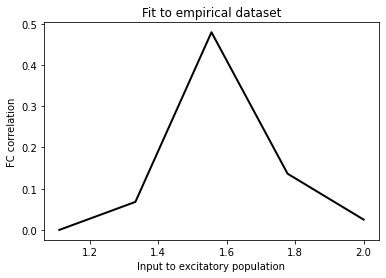

In [46]:
plt.plot(search.dfResults.mue_ext_mean, search.dfResults.fc, c='k', lw = 2)
plt.title("Fit to empirical dataset")
plt.xlabel("Input to excitatory population")
plt.ylabel("FC correlation")

## Search for optimal coupling strength

In [47]:
model.params.mue_ext_mean = search.dfResults.mue_ext_mean[search.dfResults.fc.argmax()]

In [48]:
model.params.Ke_gl

250.0

In [49]:
parameters = ParameterSpace({"Ke_gl": np.linspace(100, 400, 10)})
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename="example-1.2.1.hdf")

MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Number of processes: 10
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.2.1.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 10
MainProcess root INFO     BoxSearch: Environment initialized.


In [50]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-44M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-06-23-13H-44M-54S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-06-23-13H-44M-54S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-06-23-13H-44M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [51]:
search.loadResults()
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from ./data/hdf/example-1.2.1.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-23-13H-44M-54S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-1.2.1.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-23-13H-44M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 10/10 [00:00<00:00, 372.25it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 10/10 [00:00<00:00, 2356.88it/s]
MainProcess root

Number of results: 10


In [52]:
search.dfResults

,Ke_gl,fcd,fc
0,100.000000,0.974123,0.033562
1,133.333333,0.983341,0.066124
2,166.666667,0.980034,0.160708
3,200.000000,0.996384,0.421986
4,233.333333,0.999612,0.573198
5,266.666667,0.996180,0.513666
6,300.000000,0.999995,0.494824
7,333.333333,0.999319,0.583864
8,366.666667,0.999707,0.255026
9,400.000000,0.991411,0.086348


Text(0, 0.5, 'FC correlation')

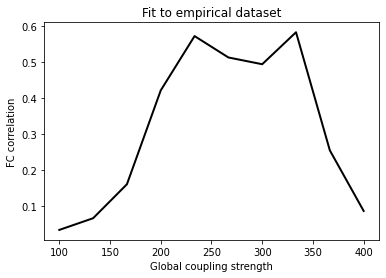

In [53]:
plt.plot(search.dfResults.Ke_gl, search.dfResults.fc, c='k', lw = 2)
plt.title("Fit to empirical dataset")
plt.xlabel("Global coupling strength")
plt.ylabel("FC correlation")